In [23]:
import wrangle
import explore
import model
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.api import Holt, ExponentialSmoothing


from sklearn.metrics import mean_squared_error
from math import sqrt 

import matplotlib.image as image

# Airline Delay Predictions

## Choose your Airline

Source: https://aspm.faa.gov/aspmhelp/index/ASQP___Carrier_Codes_And_Names.html

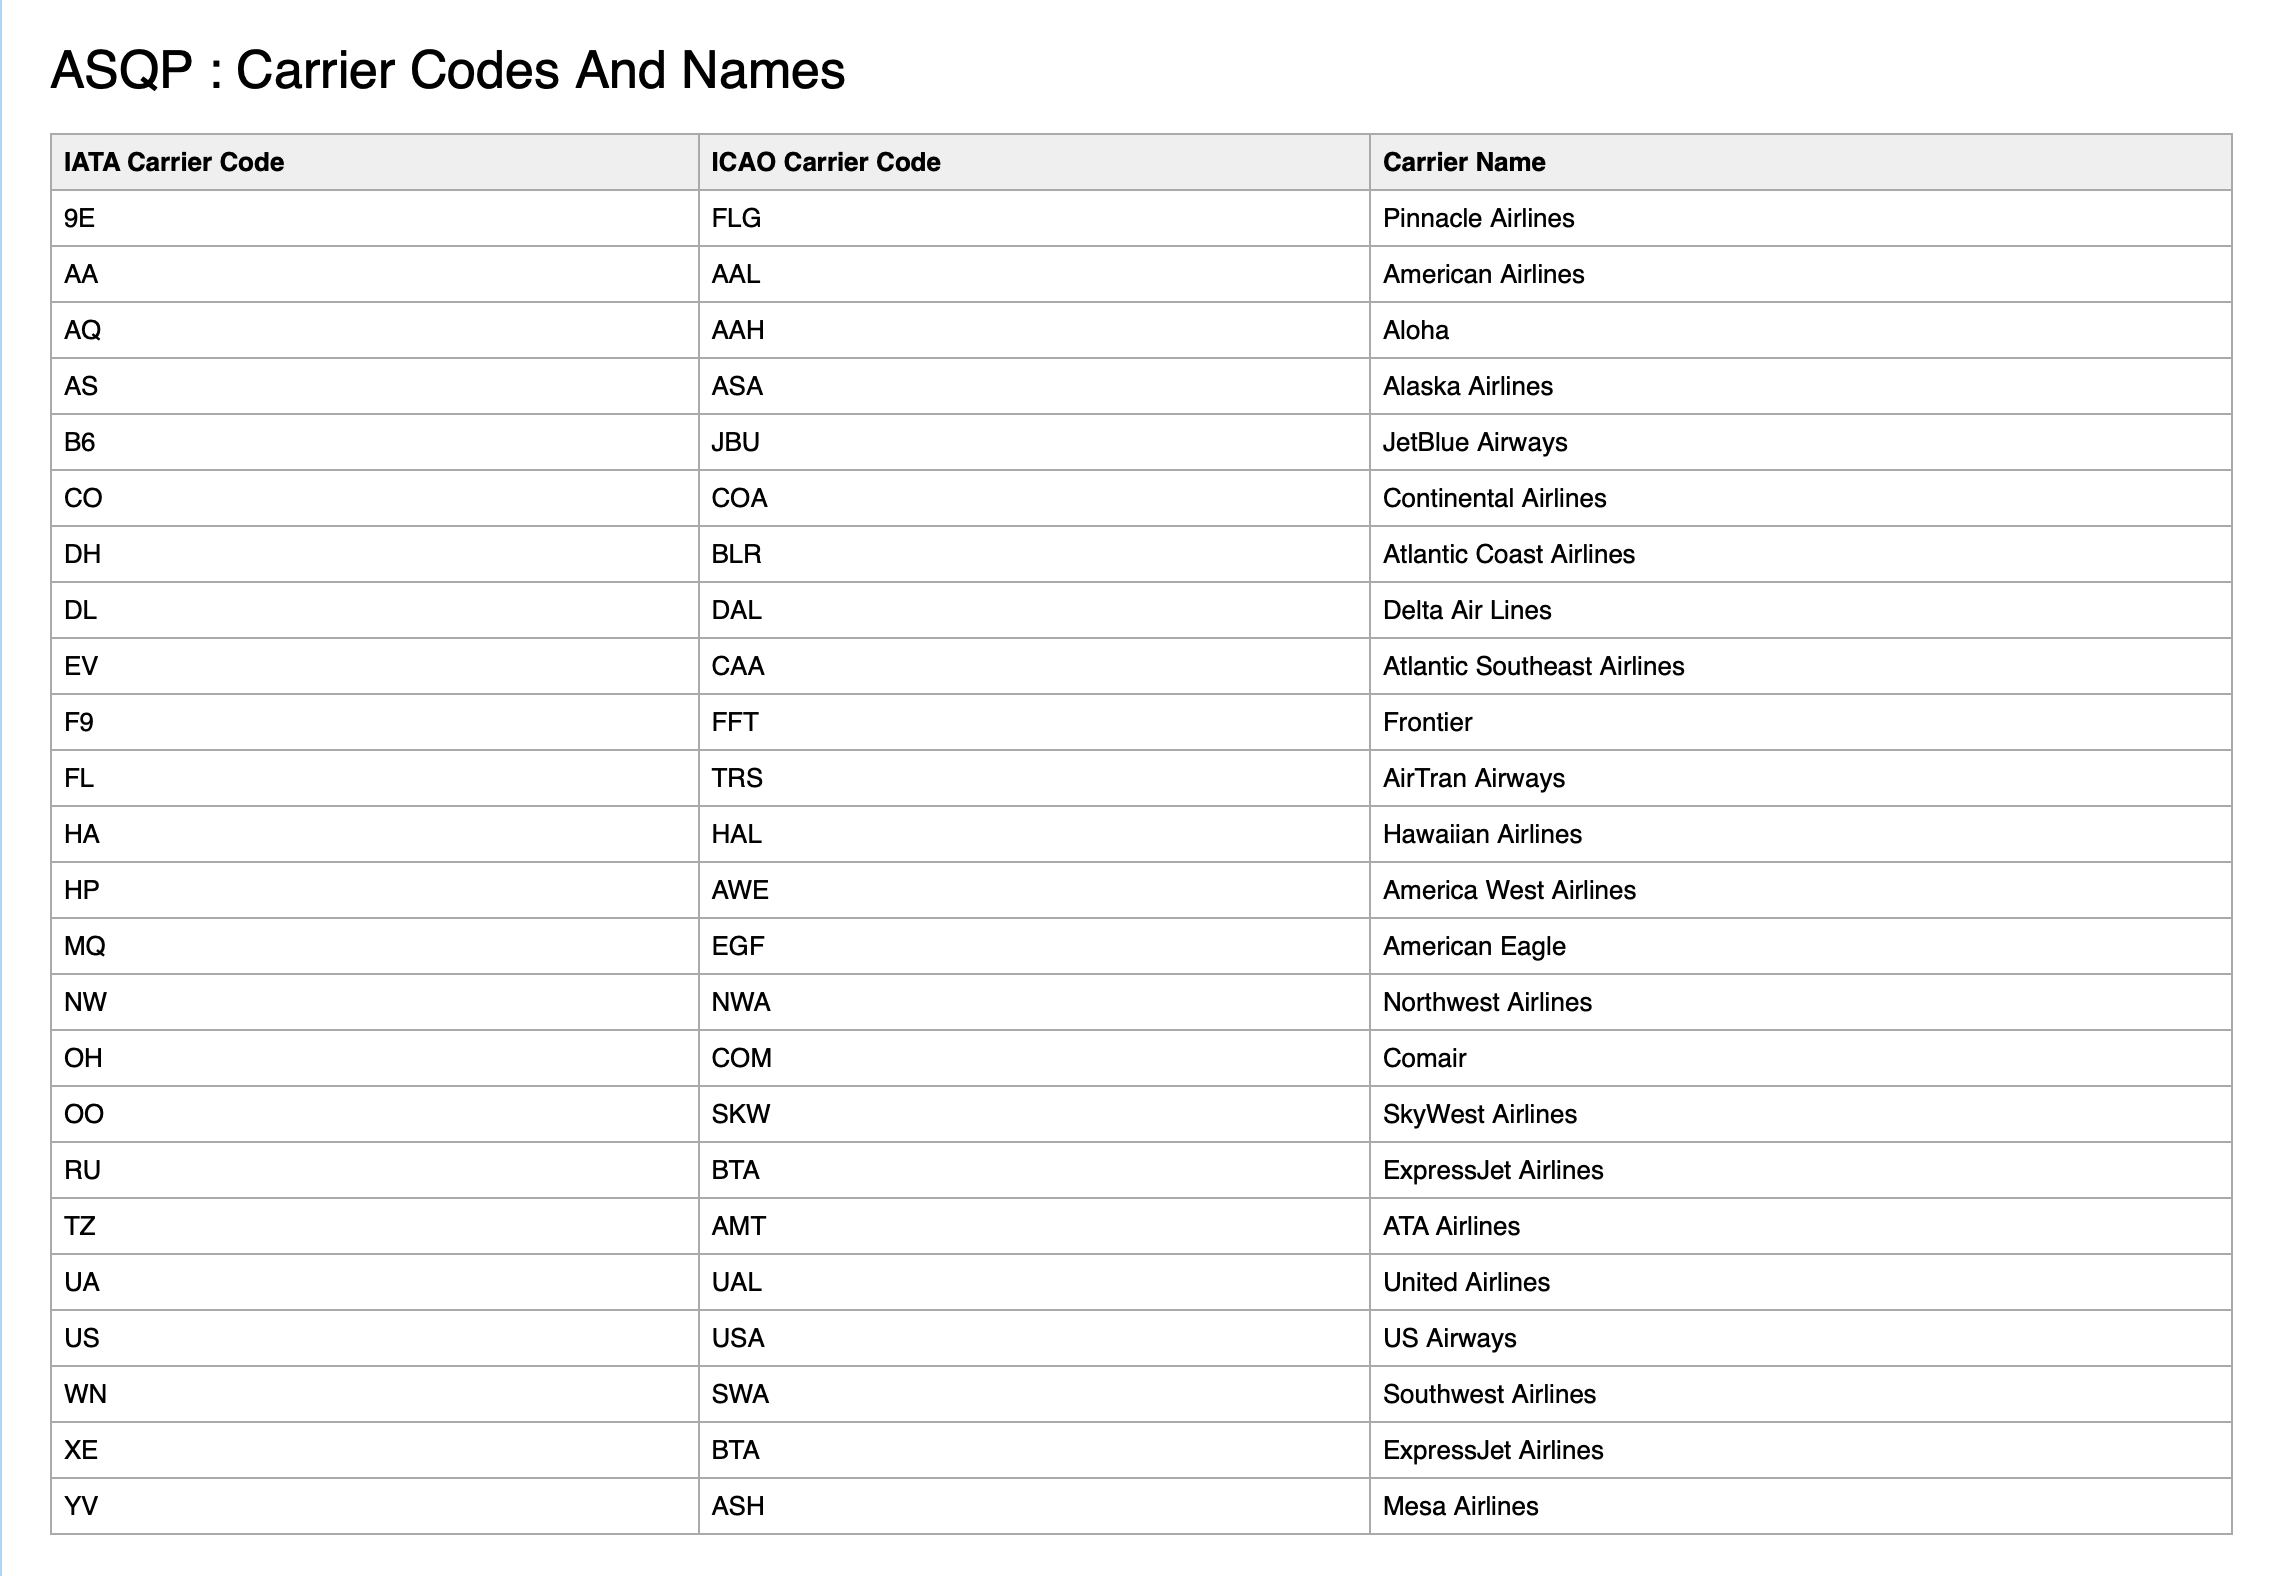

## Pull data from 10 csv's selecting the 7 columns shown out of 28 and specific to the airline passed in as the variable

Source: https://www.kaggle.com/datasets/sherrytp/airline-delay-analysis

In [24]:
flights = wrangle.pull_airline_data('DL')
flights

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
15209,2009-01-01,DL,1,MCO,JFK,6.0,0.0,0.0,0.0,52.0
15210,2009-01-01,DL,3,SLC,JFK,0.0,0.0,0.0,0.0,0.0
15211,2009-01-01,DL,4,JFK,MCO,0.0,0.0,0.0,0.0,92.0
15212,2009-01-01,DL,8,IAH,ATL,0.0,0.0,0.0,0.0,264.0
15213,2009-01-01,DL,9,ATL,JAX,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7411212,2019-12-31,DL,3092,ATL,ONT,0.0,0.0,0.0,0.0,0.0
7411213,2019-12-31,DL,3092,ONT,ATL,0.0,0.0,0.0,0.0,0.0
7411214,2019-12-31,DL,3104,EWR,SLC,0.0,0.0,0.0,0.0,0.0
7411215,2019-12-31,DL,3120,DEN,MSP,0.0,0.0,0.0,0.0,0.0


In [25]:
flights

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
15209,2009-01-01,DL,1,MCO,JFK,6.0,0.0,0.0,0.0,52.0
15210,2009-01-01,DL,3,SLC,JFK,0.0,0.0,0.0,0.0,0.0
15211,2009-01-01,DL,4,JFK,MCO,0.0,0.0,0.0,0.0,92.0
15212,2009-01-01,DL,8,IAH,ATL,0.0,0.0,0.0,0.0,264.0
15213,2009-01-01,DL,9,ATL,JAX,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7411212,2019-12-31,DL,3092,ATL,ONT,0.0,0.0,0.0,0.0,0.0
7411213,2019-12-31,DL,3092,ONT,ATL,0.0,0.0,0.0,0.0,0.0
7411214,2019-12-31,DL,3104,EWR,SLC,0.0,0.0,0.0,0.0,0.0
7411215,2019-12-31,DL,3120,DEN,MSP,0.0,0.0,0.0,0.0,0.0


## Airline on time percentage

In [26]:
print(f'Airline On Time Percentage: {flights.CARRIER_DELAY.isna().sum()/len(flights) *100: .2f}%')

Airline On Time Percentage:  0.00%


## Clean dataset imputing 0 for nulls as they represent no delay and combining all delays into one column AND then averaging the delay by day

In [27]:
flights_daily_mean = wrangle.clean_flight_data_for_average_daily_delay(flights)
flights_daily_mean

,average_delay
FL_DATE,
2009-01-01,6.232490
2009-01-02,21.230769
2009-01-03,33.540112
2009-01-04,18.426976
2009-01-05,11.786416
...,...
2019-12-27,5.398502
2019-12-28,11.199124
2019-12-29,8.268393


## Plot average by varying time intervals

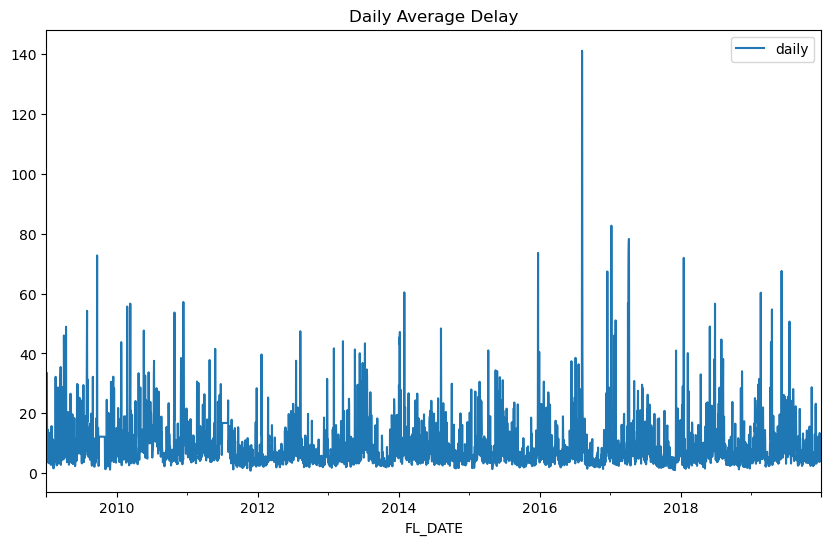

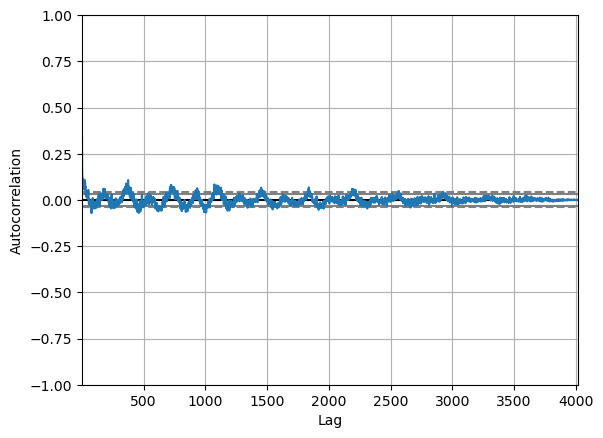

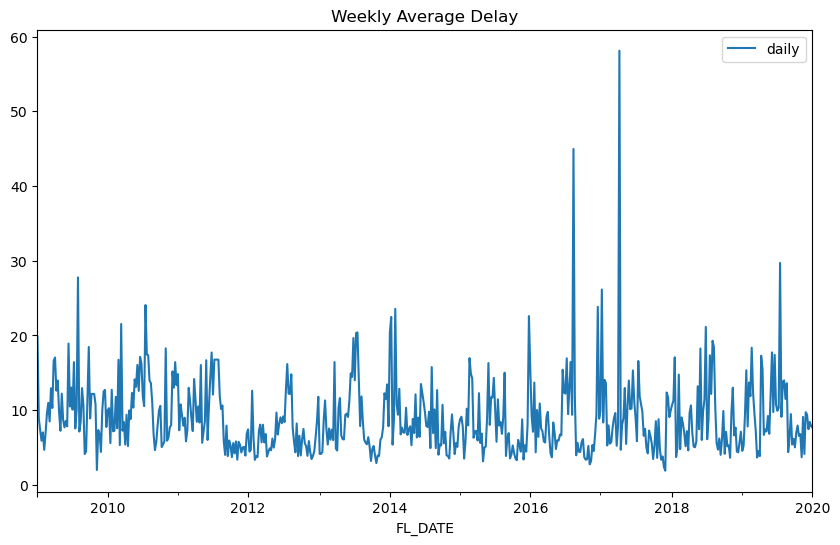

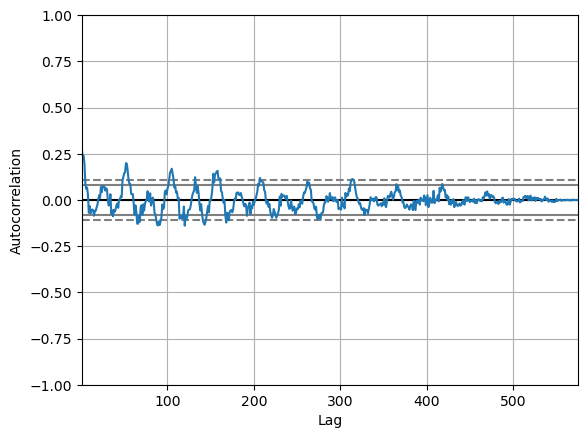

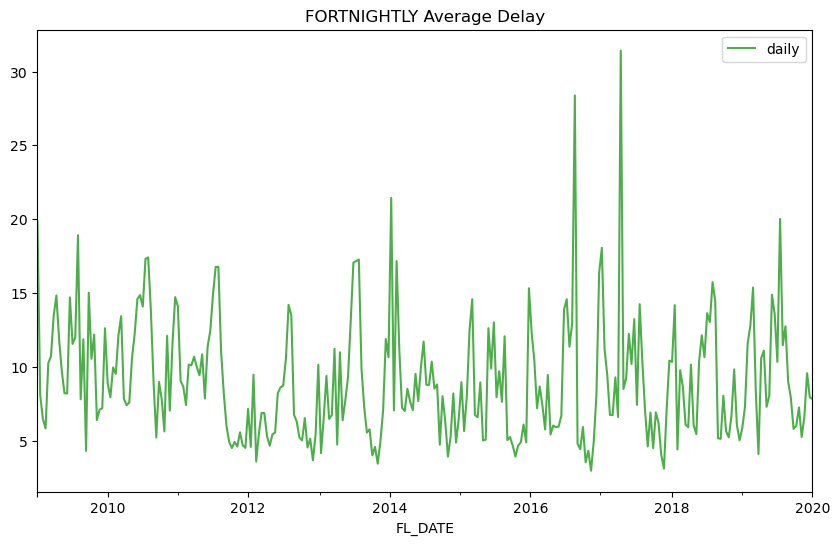

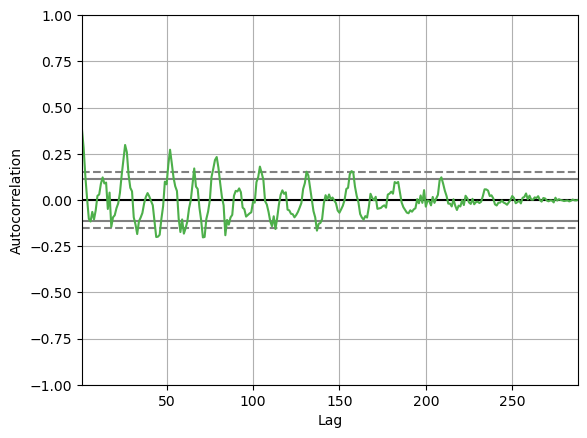

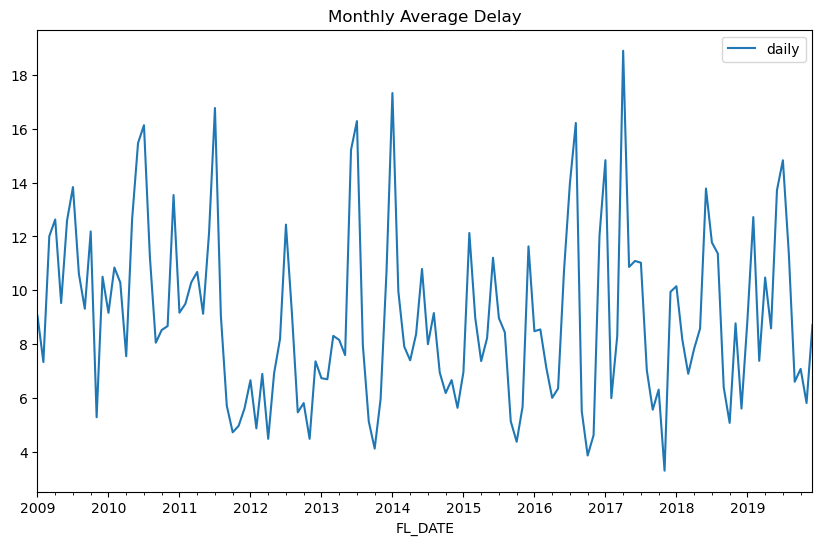

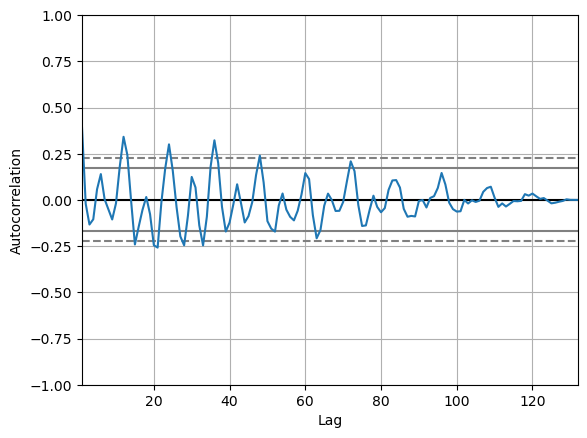

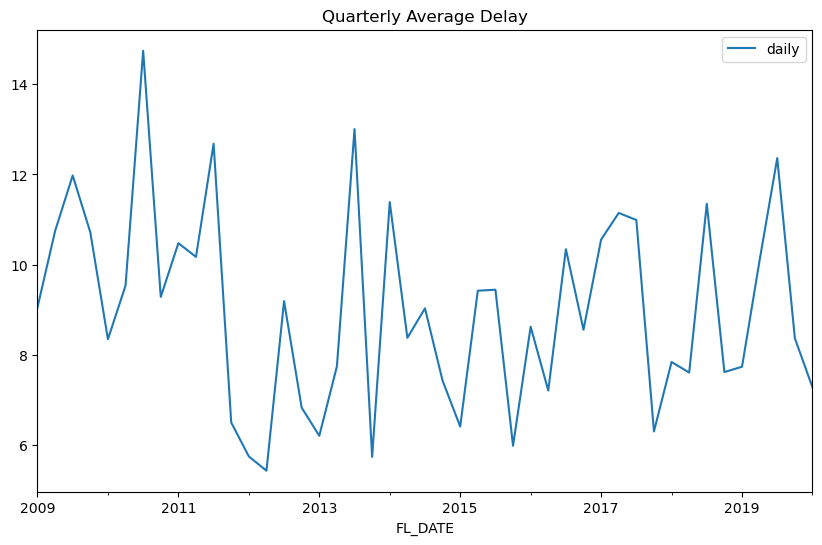

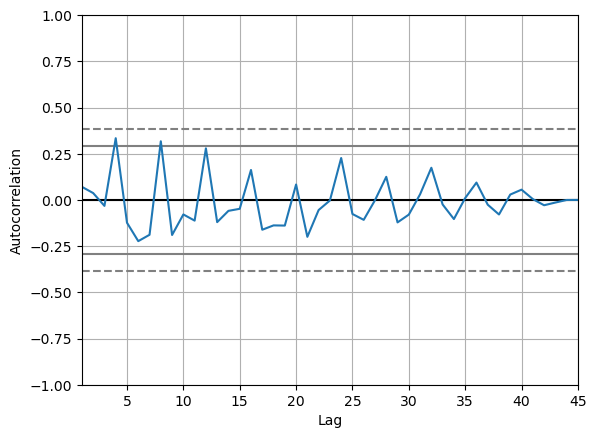

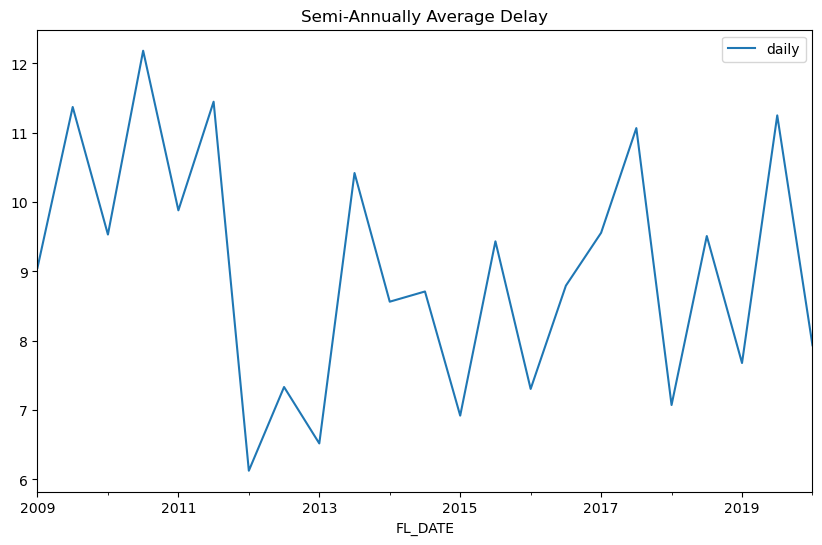

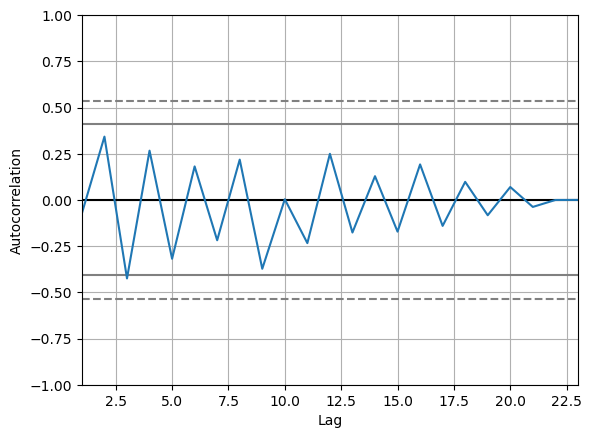

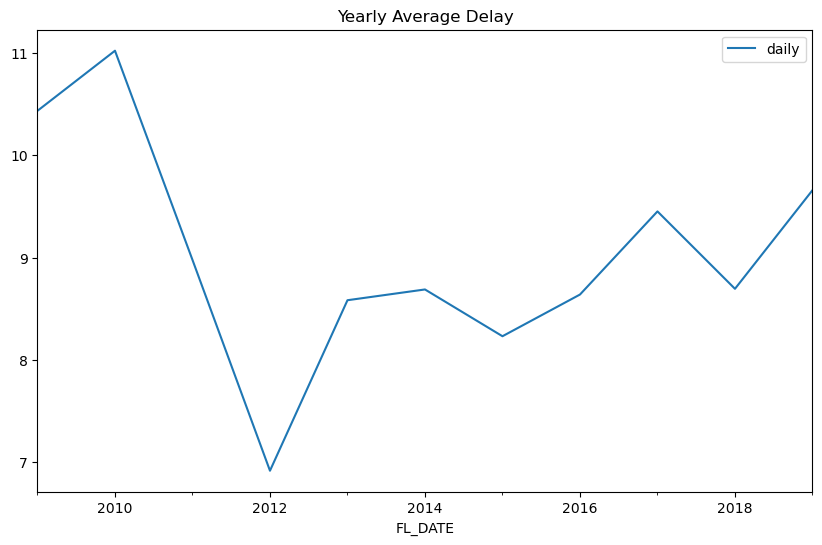

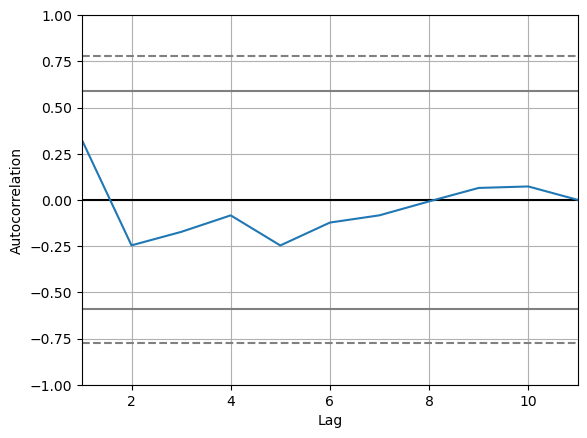

In [28]:
explore.plot_average_by_interval(flights_daily_mean)

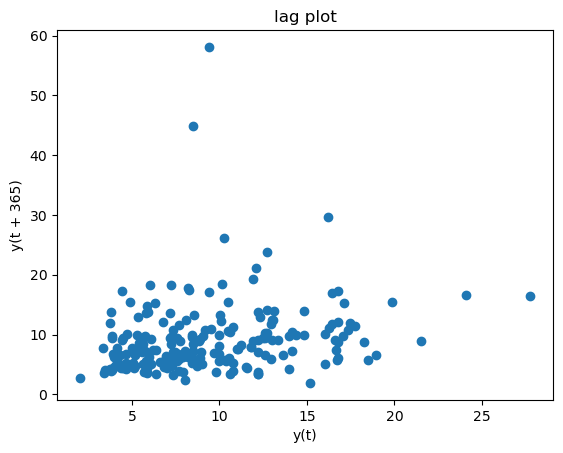

In [29]:
explore.plot_best_lag_plot(flights_daily_mean)

## Split

In [30]:
train, validate, test = model.train_test_split(flights_daily_mean, '2W')

In [31]:
train

,average_delay
FL_DATE,
2009-01-04,19.857587
2009-01-18,8.104145
2009-02-01,6.474340
2009-02-15,5.831374
2009-03-01,10.249150
...,...
2016-10-30,4.322722
2016-11-13,2.964983
2016-11-27,4.938610


## Plot the split

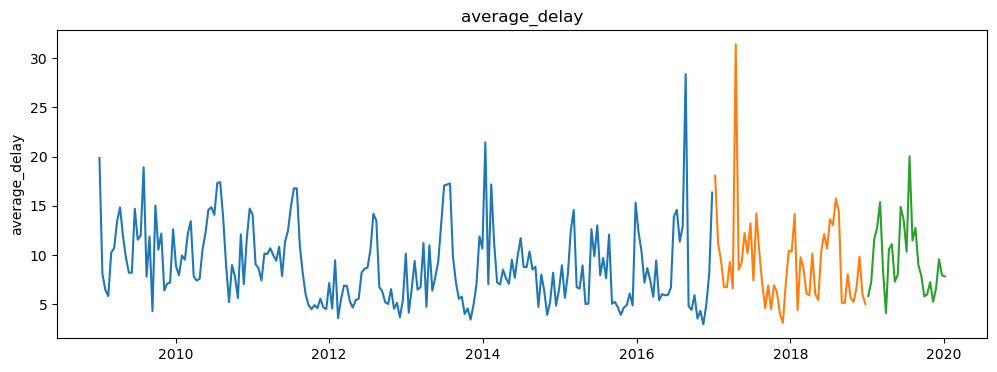

In [32]:
model.graph_split(train, validate, test)

## Seasonal Decomposition

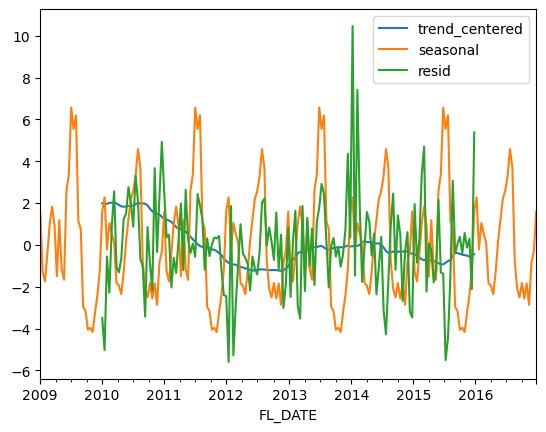

In [33]:
explore.seasonal_decomposition_plot(train, '2W')

## Baselines

In [34]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
yhat_df = pd.DataFrame(columns=['average_delay'])

### Last Average

average_delay -- RMSE: 9


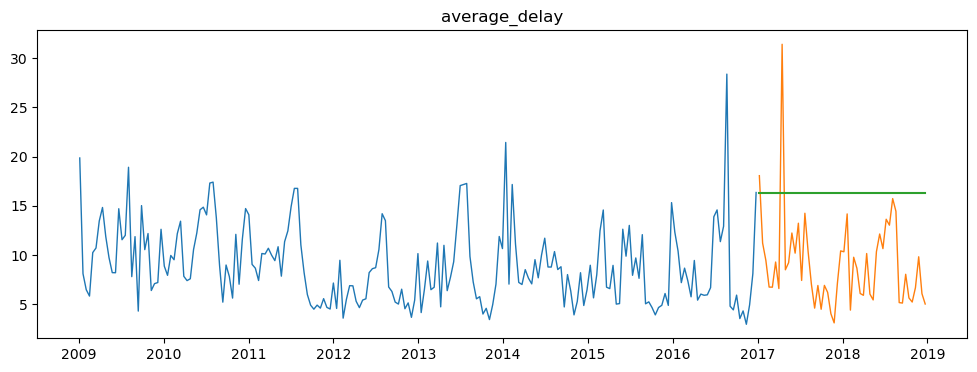

,model_type,target_var,rmse
0,last_observed_value,average_delay,8.58


In [35]:
eval_df = model.last_average_baseline(train, validate, yhat_df, eval_df)
eval_df

### Total Average

average_delay -- RMSE: 5


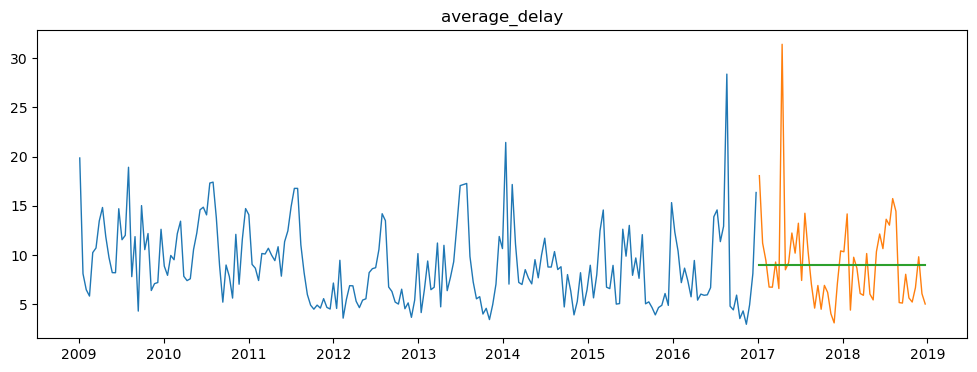

,model_type,target_var,rmse
0,last_observed_value,average_delay,8.58
0,average_of_all_test_means,average_delay,4.59


In [36]:
eval_df = model.total_average_baseline(train, validate, yhat_df, eval_df)
eval_df

### Rolling Average

In [37]:
eval_df = model.rolling_average_baselines(train, validate, yhat_df, eval_df)
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_delay,8.58
0,average_of_all_test_means,average_delay,4.59
0,rolling_average_of_1_fortnights,average_delay,8.58
0,rolling_average_of_2_fortnights,average_delay,5.55
0,rolling_average_of_6_fortnights,average_delay,5.18
0,rolling_average_of_13_fortnights,average_delay,4.60
0,rolling_average_of_26_fortnights,average_delay,4.60


#### Baseline RMSE = 4.29 minutes

## Models

In [38]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
yhat_df = pd.DataFrame(columns=['average_delay'])

### Holt's Linear Trend

average_delay -- RMSE: 5


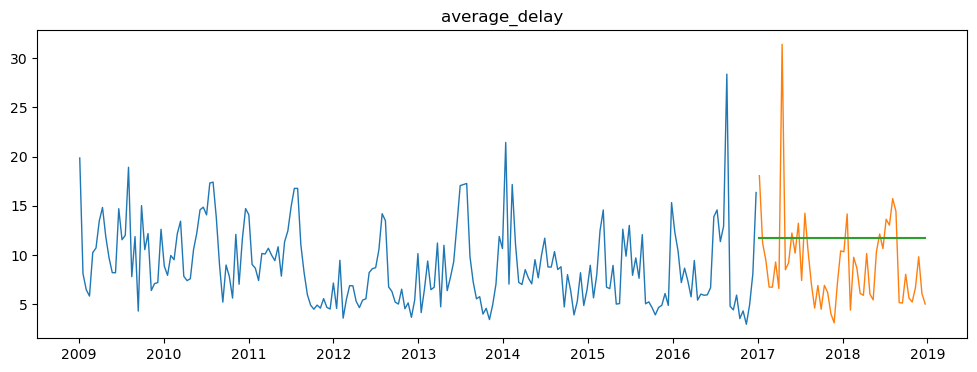

,model_type,target_var,rmse
0,holts_linear_trend,average_delay,5.26


In [39]:
eval_df = model.holt_linear(train, validate, yhat_df, eval_df)
eval_df

### Holt's Seasonal Trend

average_delay -- RMSE: 4


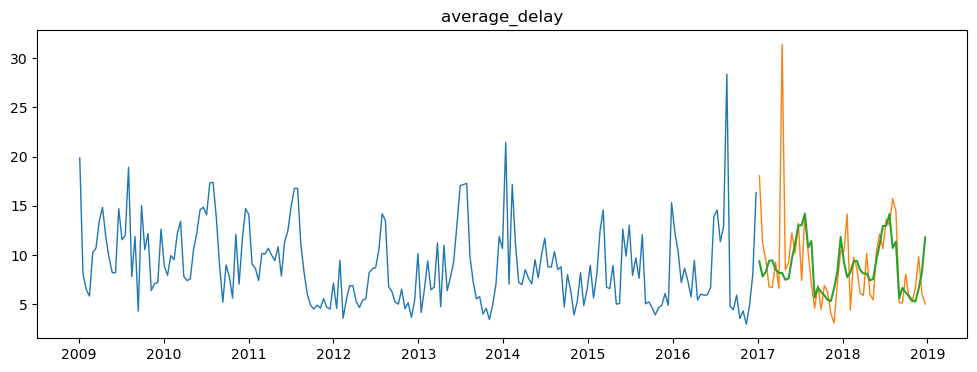

,model_type,target_var,rmse
0,holts_linear_trend,average_delay,5.26
0,holts_seasonal,average_delay,4.21


In [40]:
eval_df = model.holts_average_delay(train, validate, yhat_df, eval_df)
eval_df

### Previous Cycle

average_delay -- RMSE: 5


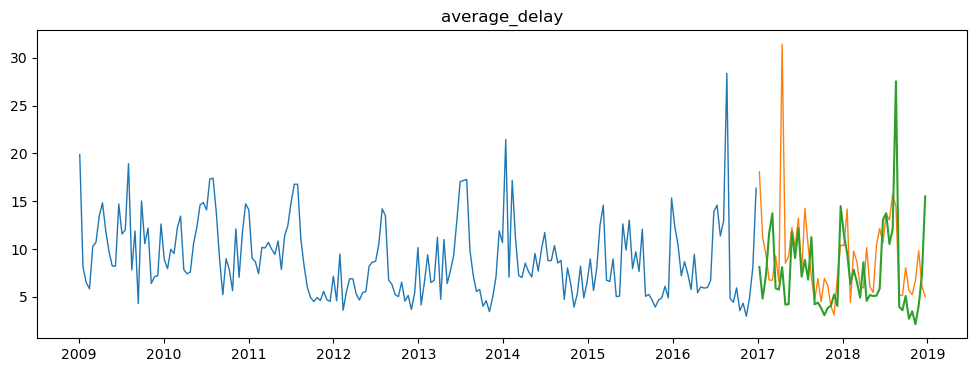

,model_type,target_var,rmse
0,holts_linear_trend,average_delay,5.26
0,holts_seasonal,average_delay,4.21
0,previous 2 years,average_delay,5.31


In [41]:
eval_df = model.previous_period(train, validate, yhat_df, eval_df)
eval_df

#### Best rmse: 3.74 minutes --- Delta: .55 minutes 

###  There seems to be no overfitting here the best model is Holt's Seasonal with Dampening

## Test

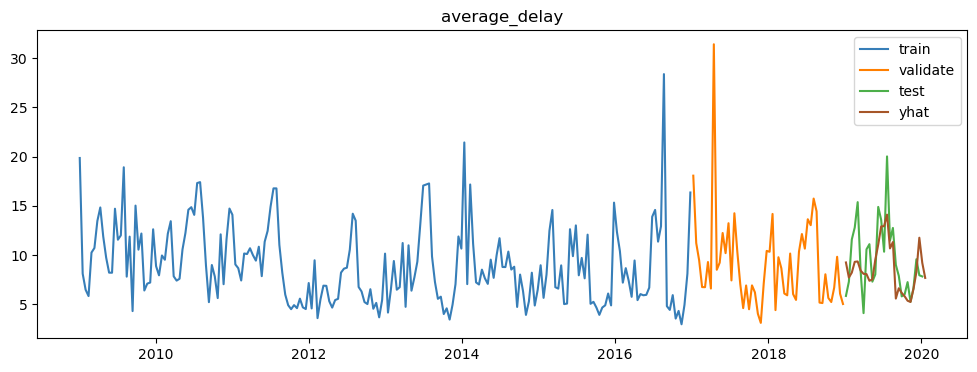

In [42]:
yhat_df = model.final_plot('average_delay', train, validate, test, yhat_df)

In [43]:
test, yhat_df = model.final_rmse(test, yhat_df)

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  2.752592166687761


### Forecast

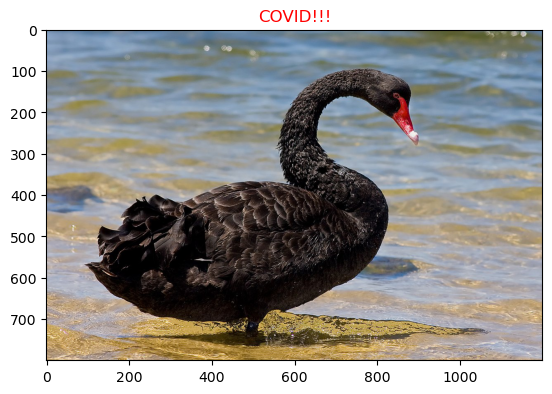

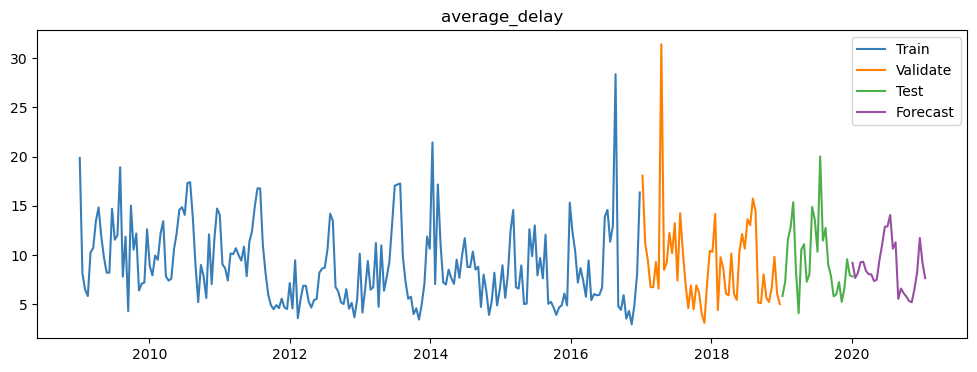

,average_delay
2020-01-05,9.210027
2020-01-19,7.675908
2020-02-02,8.177669
2020-02-16,9.274331
2020-03-01,9.314078


In [44]:
forecast = model.forecast_plot('average_delay', train, validate, test, yhat_df)
forecast.head()

# Conclusions
* There is a clear seasonality to the delays
* Our rmse is just over a minute better than basline but really is not all that useful in and of itself
* The seasonal trend IS useful and can inform expected delays given the time of the year
* There are a lot of residuals...more on that below in next steps
* Even the best models couldn't predict COVID!!!

## Next steps

### Another look at trends and residuals

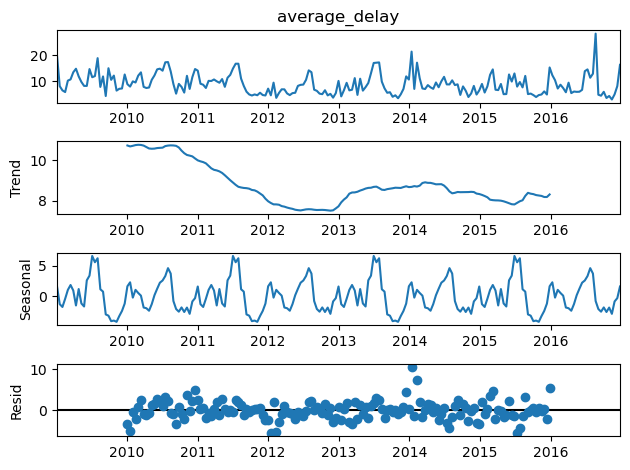

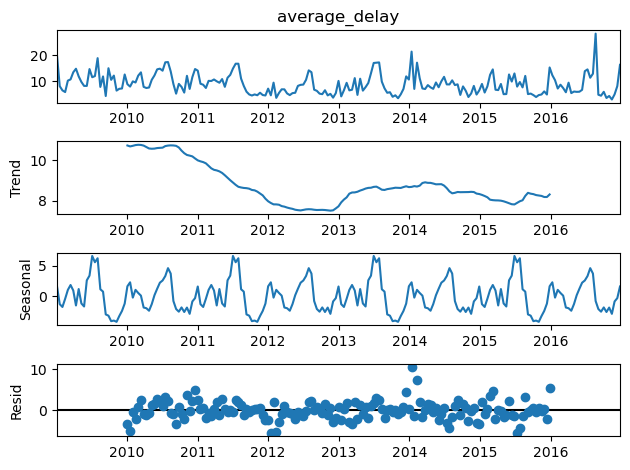

In [45]:
sm.tsa.seasonal_decompose(train['average_delay']).plot()

### Carrier/Maintenance, NAS, Military/Airshow, Accident, Presidential, Natural Disaster all take a back seat to WEATHER!
* Break down the Airline dataframes further based on individual hubs where the seasonal patterns matter
* Upload historical METAR (hourly weather observations for pilots) data for all airports and append proper info based on departure and destination airports and append appropriately to the individual observations
* Focus on winds, precipitation (amount and type), barometric pressure, visibility and cloud cover as features to predict residuals i.e. the day to day or week to week divergence from the seasonal trend in an ensemble model
* Try out FB prophet
* Finish automating the best model selection
* Look into whether I can find general weather patterns by week or month and see if I can make make a connection there

